In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Load dataset
file_path = "/content/drive/MyDrive/Minor_project6thsem/Datasets/DDoS SDN Tree/DDoS-SDN-Tree.csv"
df = pd.read_csv(file_path,low_memory=False)

In [18]:
df.shape

(164899, 35)


Training Fold 1...
Test Accuracy: 0.9572
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     15524
           1       1.00      0.92      0.96     17456

    accuracy                           0.96     32980
   macro avg       0.96      0.96      0.96     32980
weighted avg       0.96      0.96      0.96     32980



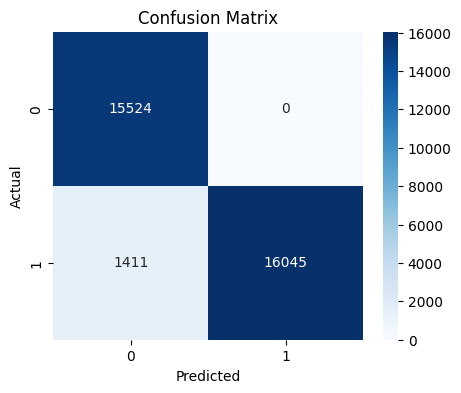

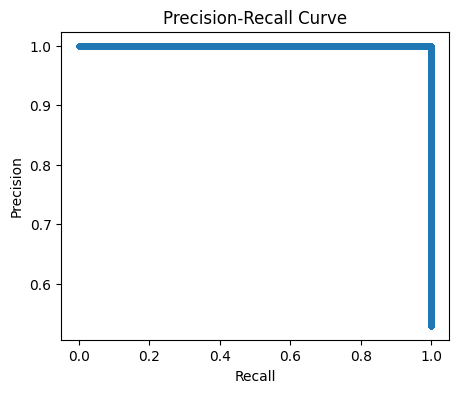

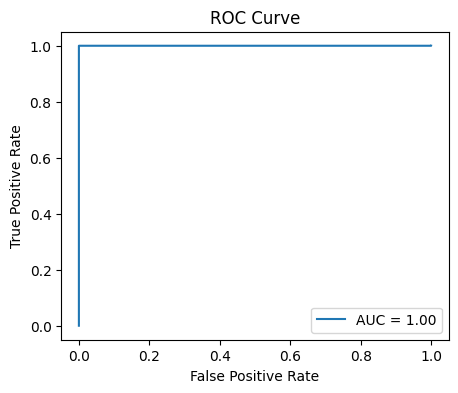

Fold 1 Accuracy: 0.9572

Training Fold 2...
Test Accuracy: 0.9658
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     15524
           1       1.00      0.94      0.97     17456

    accuracy                           0.97     32980
   macro avg       0.97      0.97      0.97     32980
weighted avg       0.97      0.97      0.97     32980



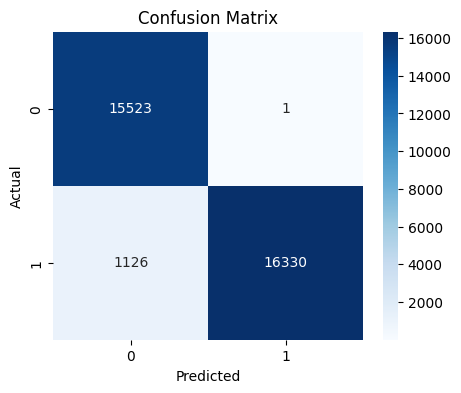

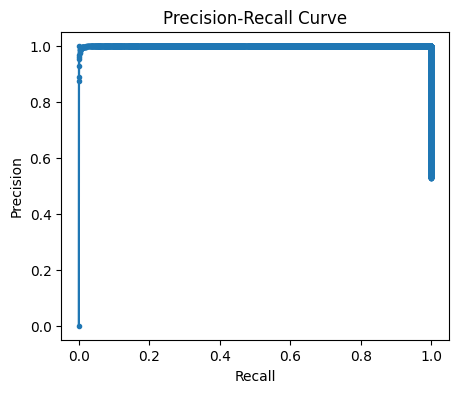

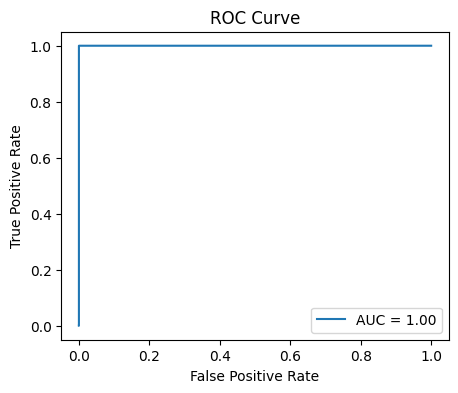

Fold 2 Accuracy: 0.9658

Training Fold 3...
Test Accuracy: 0.9775
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     15524
           1       1.00      0.96      0.98     17456

    accuracy                           0.98     32980
   macro avg       0.98      0.98      0.98     32980
weighted avg       0.98      0.98      0.98     32980



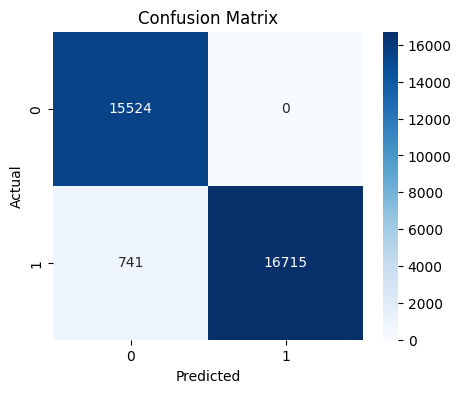

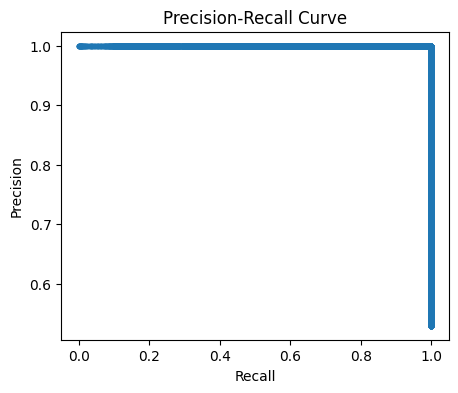

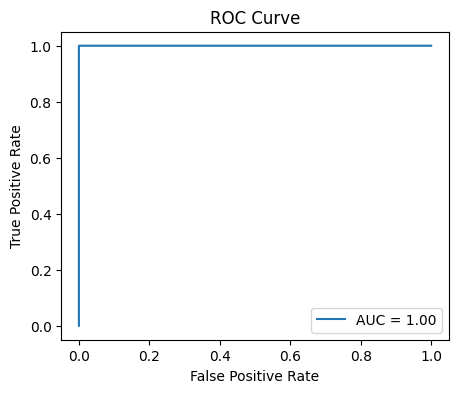

Fold 3 Accuracy: 0.9775

Training Fold 4...
Test Accuracy: 0.9917
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15523
           1       1.00      0.98      0.99     17457

    accuracy                           0.99     32980
   macro avg       0.99      0.99      0.99     32980
weighted avg       0.99      0.99      0.99     32980



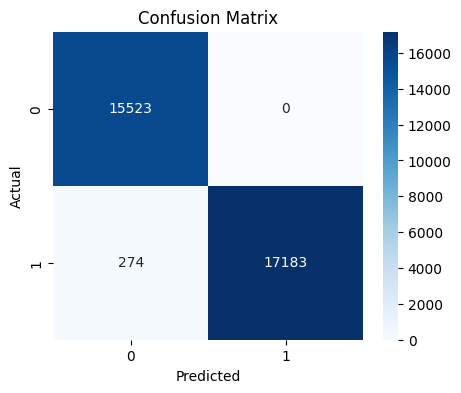

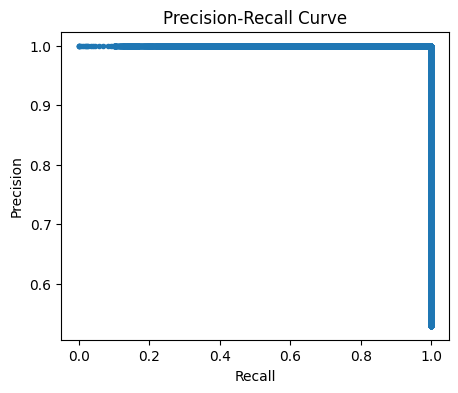

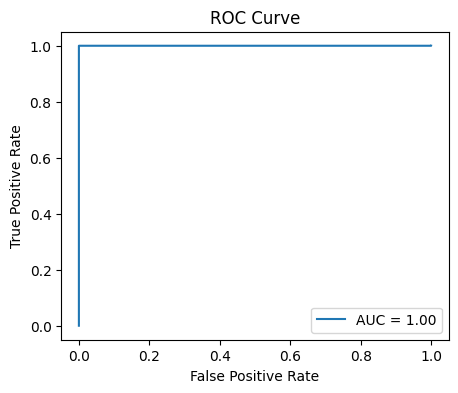

Fold 4 Accuracy: 0.9917

Training Fold 5...
Test Accuracy: 0.9785
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15523
           1       1.00      0.96      0.98     17456

    accuracy                           0.98     32979
   macro avg       0.98      0.98      0.98     32979
weighted avg       0.98      0.98      0.98     32979



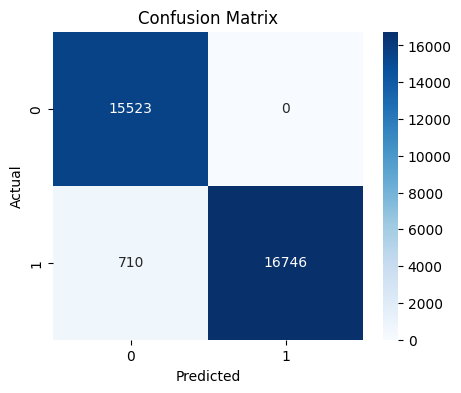

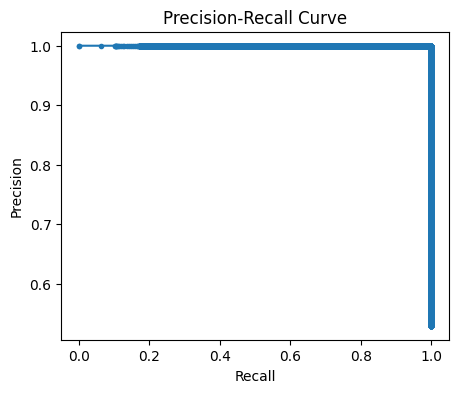

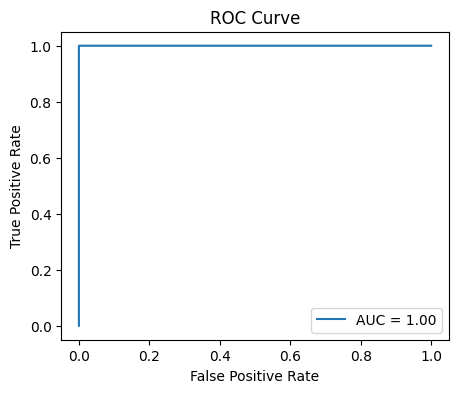

Fold 5 Accuracy: 0.9785

Final Average Accuracy: 0.9741


In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

# Load dataset (replace 'df' with actual dataset)
# df = pd.read_csv("your_dataset.csv")

# Convert numerical columns (fix European-style decimal issues)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(str)
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass

# Encode categorical variables
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['label']).values
y = df['label'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define the neural network with Batch Normalization and Dropout
class ImprovedFedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedFedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Function to split data into federated clients
def split_federated_data(indices, X, y, num_clients=5):
    split_size = len(indices) // num_clients
    client_datasets = []
    for i in range(num_clients):
        start = i * split_size
        end = (i + 1) * split_size if i != num_clients - 1 else len(indices)
        dataset = Subset(TensorDataset(X[indices], y[indices]), range(start, end))
        client_datasets.append(DataLoader(dataset, batch_size=64, shuffle=True))
    return client_datasets

# Federated averaging function
def federated_averaging(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack(
            [client_models[i].state_dict()[key].float() for i in range(len(client_models))], dim=0
        ).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

# Train federated clients
def train_federated(global_model, client_loaders, epochs=10, patience=3):
    criterion = nn.CrossEntropyLoss()
    best_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        client_models = []
        for client_loader in client_loaders:
            model = ImprovedFedNN(input_size=X.shape[1])
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)

            model.train()
            for X_batch, y_batch in client_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            client_models.append(model)

        federated_averaging(global_model, client_models)

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())
            y_probs.extend(torch.softmax(outputs, dim=1)[:, 1].numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return acc

# 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"\nTraining Fold {fold+1}...")
    client_loaders = split_federated_data(train_idx, X_tensor, y_tensor, num_clients=5)
    test_loader = DataLoader(TensorDataset(X_tensor[val_idx], y_tensor[val_idx]), batch_size=64, shuffle=False)

    global_model = ImprovedFedNN(input_size=X.shape[1])
    train_federated(global_model, client_loaders, epochs=10, patience=3)

    final_acc = evaluate_model(global_model, test_loader)
    fold_accuracies.append(final_acc)
    print(f"Fold {fold+1} Accuracy: {final_acc:.4f}")

print(f"\nFinal Average Accuracy: {np.mean(fold_accuracies):.4f}")


Final Average Accuracy: 0.9741